In [20]:
!pip install tensorflow


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/cf/24/271e77c22724f370c24c705f394b8035b4d27e4c2c6339f3f45ab9b8258e/tensorflow-2.18.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for tensorflow-intel==2.18.0 from https://files.pythonhosted.org/packages/76/ad/fa6c508a15ff79cb5409294c293388e0999b7d480f84b65e4287277434fe/tensorflow_intel-2.18.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for absl-py>=1.0.0 from https://files.pythonhosted.org/packages/a2/ad/e0d3c824784ff121c03cc031f944bc7e139a8f1870ffd2845cc2dd76f6c4/absl_py-2.1.0-py3-none-any.whl.metadata
  Obtaining dependency information for astunparse>=1.6.0 from https://files.pythonhosted.org/packages/2b/03/13dde6512ad7b4557eb792fbcf0c653af6076b81e5941d36ec61f7ce6028/astunparse-1.6.3-py2.py3-none-any.whl.metadata
  Obtaining dependency information for flatbuffers>=24.3.25 from https://files.pythonhosted.org/packages/41/f0/7e988a019bc54b2d

# Análisis de Scouts de Fútbol: Identificación de Talentos

In [101]:
# Importación de librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Para procesamiento
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Para modelos
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from scipy.spatial.distance import cdist

In [73]:
# Configuración de visualización
plt.style.use("seaborn-v0_8")
%matplotlib inline
sns.set_theme(style="whitegrid")

In [74]:
# Carga y Exploración Inicial de Datos
def cargar_datos():
    """
    Carga los datasets de jugadores y atributos de jugadores
    """
    # Cargar archivos
    players = pd.read_csv('Player.csv')
    player_attributes = pd.read_csv('Player_Attributes.csv')
    
    print("Dimensiones de los datasets:")
    print(f"Players: {players.shape}")
    print(f"Player Attributes: {player_attributes.shape}")
    
    return players, player_attributes

### 1. Preprocesamiento de Datos
En esta sección se realiza la limpieza y preparación inicial de los datos. Sus principales tareas son:
- Calcula la edad de los jugadores a partir de su fecha de nacimiento
- Convierte todas las columnas numéricas al formato correcto
- Calcula promedios de atributos por jugador
- Identifica jugadores elite (top 10% según overall_rating)
- Elimina registros con valores faltantes en campos críticos

In [ ]:
# Preprocesamiento de Datos

def calcular_edad(fecha_nacimiento):
    """Calcula la edad del jugador"""
    try:
        fecha_limpia = fecha_nacimiento.split(' ')[0]
        nacimiento = datetime.strptime(fecha_limpia, '%Y-%m-%d')
        fecha_referencia = datetime(2017, 1, 1)
        return fecha_referencia.year - nacimiento.year - (
            (fecha_referencia.month, fecha_referencia.day) < 
            (nacimiento.month, nacimiento.day)
        )
    except:
        return None

def preprocesar_datos(players, player_attributes):
    """
    Realiza el preprocesamiento completo de los datos
    """
    print("\n=== Inicio del Preprocesamiento ===")
    print(f"Datos iniciales:")
    print(f"Total de jugadores en dataset: {len(players)}")
    print(f"Total de registros de atributos: {len(player_attributes)}")

    # Lista de columnas numéricas
    numeric_columns = [
        'overall_rating', 'potential', 'crossing', 'finishing',
        'heading_accuracy', 'short_passing', 'volleys', 'dribbling',
        'curve', 'free_kick_accuracy', 'long_passing', 'ball_control',
        'acceleration', 'sprint_speed', 'agility', 'reactions',
        'balance', 'shot_power', 'jumping', 'stamina', 'strength',
        'long_shots'
    ]
    
    # 1. Calcular edad
    players['edad'] = players['birthday'].apply(calcular_edad)
    print(f"\nCálculo de edades:")
    print(f"Rango de edades: {players['edad'].min()} - {players['edad'].max()} años")
    print(f"Edad promedio: {players['edad'].mean():.1f} años")
    
    # 2. Convertir columnas a numérico y calcular promedios
    print("\nConvirtiendo atributos a valores numéricos...")
    for col in numeric_columns:
        player_attributes[col] = pd.to_numeric(player_attributes[col], errors='coerce')
    
    attrs_avg = player_attributes.groupby('player_api_id')[numeric_columns].mean()
    print(f"Jugadores con atributos promediados: {len(attrs_avg)}")
    
    # 3. Unir datos y limpiar
    print("\nUniendo datos de jugadores con sus atributos...")
    df_completo = players.merge(
        attrs_avg,
        left_on='player_api_id',
        right_index=True,
        how='inner'
    )
    print(f"Registros después de unión: {len(df_completo)}")
    
    # Eliminar nulos
    antes_nulos = len(df_completo)
    df_completo = df_completo.dropna(subset=numeric_columns + ['edad'])
    eliminados = antes_nulos - len(df_completo)
    print(f"Registros eliminados por valores nulos: {eliminados}")
    
    # 4. Definir jugadores elite
    umbral_elite = df_completo['overall_rating'].quantile(0.9)
    df_completo['es_elite'] = (
        df_completo['overall_rating'] >= umbral_elite
    ).astype(int)
    
    print(f"\nEstadísticas finales:")
    print(f"Total jugadores procesados: {len(df_completo)}")
    print(f"Jugadores elite (top 10%): {df_completo['es_elite'].sum()}")
    print(f"Rating mínimo para elite: {umbral_elite:.1f}")
    print(f"Rating promedio: {df_completo['overall_rating'].mean():.1f}")
    
    # Mostrar ejemplo de jugadores elite
    print("\nEjemplos de jugadores elite:")
    elite_examples = df_completo[df_completo['es_elite'] == 1].sample(3)
    print(elite_examples[['player_name', 'edad', 'overall_rating']].to_string())
    
    return df_completo

### 2. Análisis Exploratorio
Este análisi nos permite entender la distribución y relaciones en nuestros datos:
- Visualiza la distribución de ratings de jugadores
- Muestra la relación entre edad y rendimiento
- Genera un mapa de calor de correlaciones entre atributos
- Identifica patrones y tendencias en los datos

In [87]:
def realizar_eda(df):
    """
    Realiza el análisis exploratorio de datos y visualizaciones clave
    """
    # Definir atributos principales
    atributos_principales = [
        'overall_rating', 'potential', 'finishing',
        'dribbling', 'ball_control', 'acceleration', 'sprint_speed'
    ]

    # Configurar estilo de las gráficas
    plt.style.use('seaborn-v0_8')
    
    # 1. Distribución de Overall Rating y Categoría Elite
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(data=df, x='overall_rating', bins=30)
    plt.title('Distribución de Overall Rating')
    
    plt.subplot(1, 2, 2)
    sns.histplot(data=df, x='overall_rating', hue='es_elite', bins=30)
    plt.title('Distribución por Categoría Elite')
    plt.tight_layout()
    plt.show()

    # 2. Relación Edad vs Rating
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='edad', y='overall_rating', hue='es_elite', alpha=0.6)
    plt.title('Relación entre Edad y Overall Rating')
    plt.show()

    # 3. Mapa de calor de correlaciones
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        df[atributos_principales].corr(), 
        annot=True, 
        cmap='coolwarm',
        fmt='.2f'
    )
    plt.title('Correlación entre Atributos Principales')
    plt.show()

    # 4. Estadísticas descriptivas
    print("\nEstadísticas descriptivas:")
    print(df[atributos_principales].describe().round(2))

    
    return atributos_principales


### 3. Preparación para Modelado
Prepara los datos para ser utilizados en los modelos de machine learning:
- Divide los datos en conjuntos de entrenamiento y prueba
- Escala las características para normalizarlas
- Asegura que los datos estén en el formato correcto para los modelos

In [91]:
# Preparación para Modelado
def preparar_datos_modelo(df, atributos_principales):
    """
    Prepara los datos para el modelado
    """
    print("\n=== Preparación de Datos para Modelado ===")
    
    # Seleccionar características
    X = df[atributos_principales]
    y = df['es_elite']
    
    # División train-test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Escalar datos
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print(f"\nDimensiones de los datos:")
    print(f"X_train: {X_train_scaled.shape}")
    print(f"X_test: {X_test_scaled.shape}")
    print(f"y_train: {y_train.shape}")
    print(f"y_test: {y_test.shape}")
    
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler

### 4. Autoencoder
El autoencoder es una red neuronal que aprende a comprimir y reconstruir los datos:
- **Encoder**: Comprime los datos de entrada a una dimensión menor
- **Decoder**: Intenta reconstruir los datos originales
- Ayuda a encontrar patrones ocultos en los datos
- Reduce la dimensionalidad manteniendo la información más importante

Este paso es crucial para:
1. Reducir la complejidad de los datos
2. Encontrar patrones subyacentes
3. Mejorar la eficiencia del análisis posterior

In [93]:
def crear_autoencoder(input_dim, encoding_dim=5):
    """
    Crea un autoencoder para reducción de dimensionalidad
    """
    # Arquitectura del modelo
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(encoding_dim * 2, activation='relu')(input_layer)
    encoded = Dense(encoding_dim, activation='relu')(encoded)
    
    decoded = Dense(encoding_dim * 2, activation='relu')(encoded)
    decoded = Dense(input_dim, activation='sigmoid')(decoded)
    
    # Crear modelos
    autoencoder = Model(input_layer, decoded)
    encoder = Model(input_layer, encoded)
    
    # Compilar
    autoencoder.compile(optimizer='adam', loss='mse')
    
    return autoencoder, encoder

def entrenar_autoencoder(autoencoder, X_train_scaled, X_test_scaled):
    """
    Entrena el autoencoder con early stopping
    """
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
    
    # Entrenar modelo
    history = autoencoder.fit(
        X_train_scaled,
        X_train_scaled,
        epochs=50,
        batch_size=32,
        validation_data=(X_test_scaled, X_test_scaled),
        callbacks=[early_stopping],
        verbose=0
    )
    
    # Graficar pérdida
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], 'b', label='Training')
    plt.plot(history.history['val_loss'], 'r', label='Validation')
    plt.title('Model Loss')
    plt.legend()
    plt.show()
    
    return history

### 5. Random Forest
Implementa un clasificador Random Forest para identificar jugadores elite:
- Utiliza las características comprimidas del autoencoder
- Construye múltiples árboles de decisión
- Combina sus predicciones para mayor precisión
- Proporciona importancia de características

El Random Forest es efectivo porque:
- Maneja bien datos no lineales
- Es resistente al overfitting
- Proporciona medidas de importancia de características

In [94]:
def entrenar_random_forest(X_encoded_train, y_train):
    """
    Entrena el modelo Random Forest y muestra importancia de características
    """
    # Entrenar modelo
    rf_model = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        random_state=42
    )
    rf_model.fit(X_encoded_train, y_train)
    
    # Mostrar importancia de características
    importances = pd.DataFrame({
        'feature': range(X_encoded_train.shape[1]),
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    print("\nImportancia de características:")
    print(importances)
    
    return rf_model

### 6. Evaluación de Modelos
Evalúa el rendimiento de los modelos mediante:
- Métricas de clasificación (precisión, recall, f1-score)
- Matriz de confusión
- Visualizaciones de rendimiento

In [95]:
def evaluar_modelo(y_true, y_pred, nombre_modelo):
    """
    Evalúa el modelo mostrando métricas y matriz de confusión
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_true, y_pred), 
                annot=True, 
                fmt='d', 
                cmap='Blues')
    plt.title(f'Confusion Matrix - {nombre_modelo}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    print(f"\nMétricas de evaluación - {nombre_modelo}:")
    print(classification_report(y_true, y_pred))

### 7. Sistema de Recomendación
Implementa un sistema para encontrar jugadores similares basado en:
- Características codificadas por el autoencoder
- Distancias en el espacio latente
- Métricas de similitud

Este sistema es útil para:
- Encontrar talentos similares a jugadores exitosos
- Identificar posibles reemplazos para jugadores
- Descubrir talentos ocultos

In [96]:
def encontrar_jugadores_similares(jugador_id, encoder, scaler, df, n_similares=5):
    """
    Encuentra jugadores similares usando el espacio latente del autoencoder
    """
    # Verificar existencia del jugador
    if jugador_id not in df['player_api_id'].values:
        print("Jugador no encontrado")
        return None

    # Características para comparación
    features = ['overall_rating', 'potential', 'finishing', 'dribbling', 
                'ball_control', 'acceleration', 'sprint_speed']

    # Procesar datos y encontrar similares    
    X_encoded = encoder.predict(scaler.transform(df[features]))
    jugador_encoded = X_encoded[df['player_api_id'] == jugador_id]
    distancias = cdist(jugador_encoded, X_encoded, 'euclidean')[0]
    
    # Retornar jugadores similares (excluyendo al jugador de referencia)
    indices_similares = np.argsort(distancias)[1:n_similares+1]
    return df.iloc[indices_similares]

# FLUJO
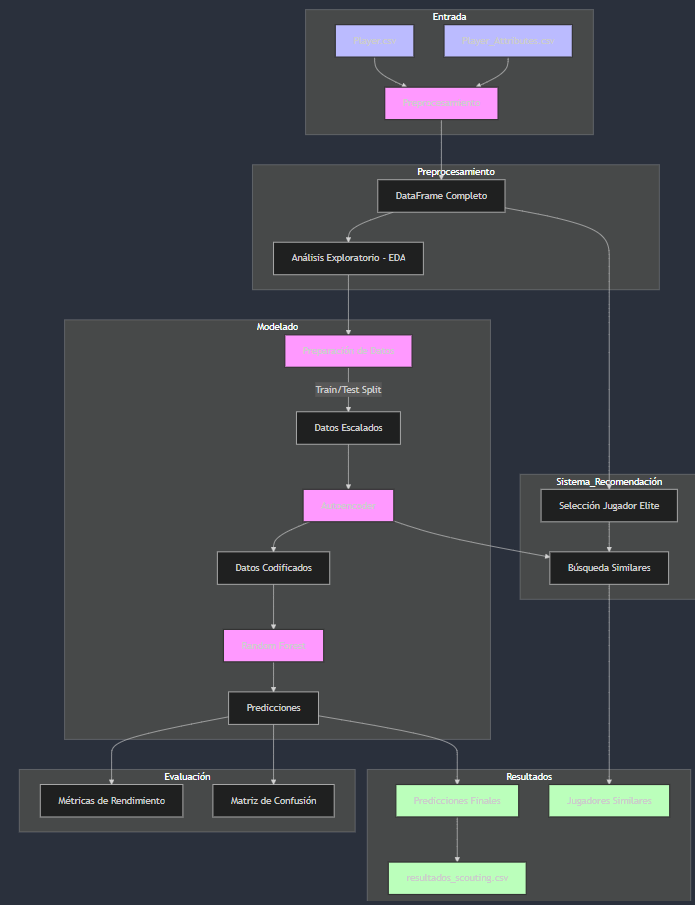

# MODELO
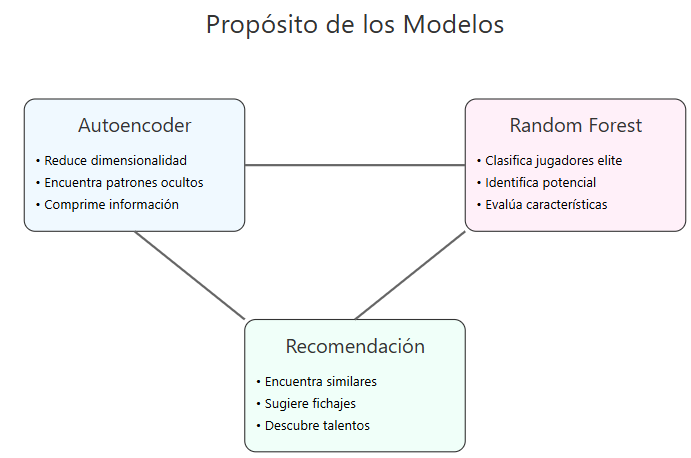

In [85]:
# 1. Carga de Datos
players, player_attributes = cargar_datos()

# Preprocesamiento de Datos
df_completo = preprocesar_datos(players, player_attributes)

Dimensiones de los datasets:
Players: (11060, 7)
Player Attributes: (183978, 42)

=== Inicio del Preprocesamiento ===
Datos iniciales:
Total de jugadores en dataset: 11060
Total de registros de atributos: 183978

Cálculo de edades:
Rango de edades: 24 - 56 años
Edad promedio: 36.4 años

Convirtiendo atributos a valores numéricos...
Jugadores con atributos promediados: 11060

Uniendo datos de jugadores con sus atributos...
Registros después de unión: 11060
Registros eliminados por valores nulos: 478

Estadísticas finales:
Total jugadores procesados: 10582
Jugadores elite (top 10%): 1059
Rating mínimo para elite: 74.8
Rating promedio: 66.9

Ejemplos de jugadores elite:
         player_name  edad  overall_rating
10733   Wayne Rooney    38       87.222222
1884   Clint Dempsey    40       79.743590
778     Andy Carroll    34       75.037037


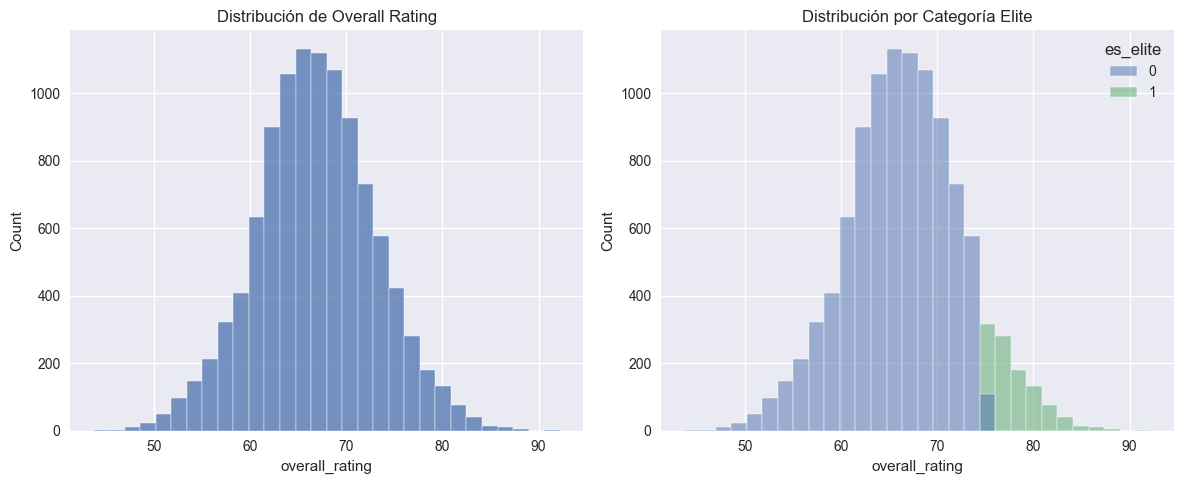

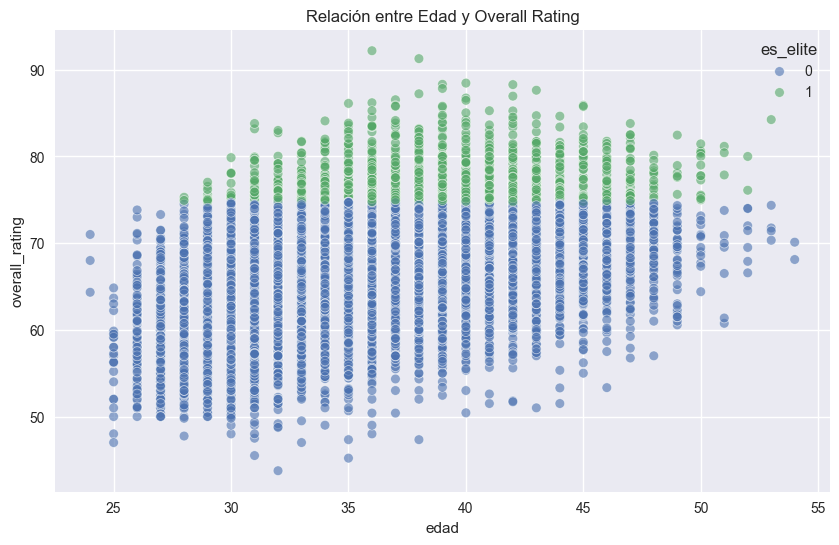

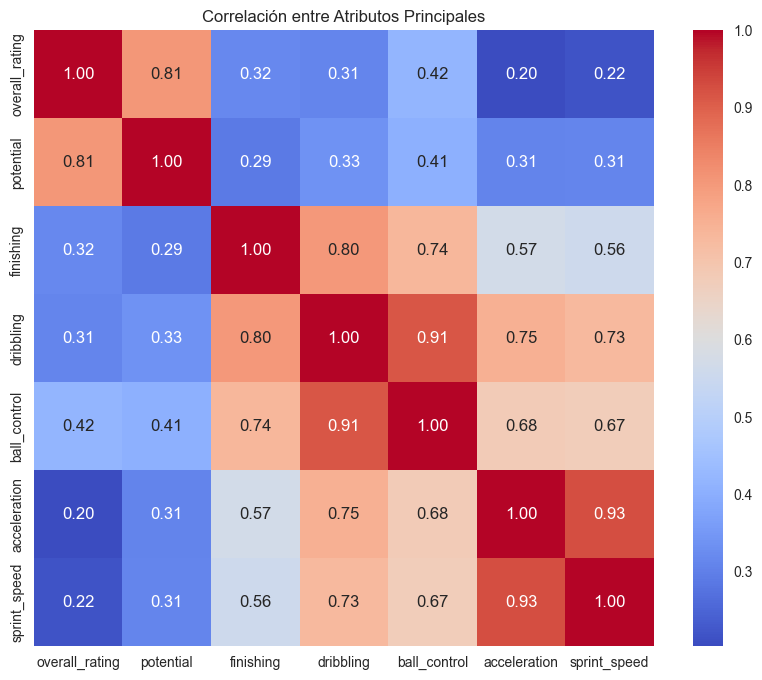


Estadísticas descriptivas:
       overall_rating  potential  finishing  dribbling  ball_control  \
count        10582.00   10582.00   10582.00   10582.00      10582.00   
mean            66.88      72.13      47.87      57.06         61.22   
std              6.17       5.73      18.16      16.90         14.60   
min             43.75      51.00       5.00       5.14          9.00   
25%             62.91      68.05      32.43      49.50         57.00   
50%             66.79      72.06      50.00      61.33         64.40   
75%             70.95      76.00      63.13      68.94         70.43   
max             92.19      95.23      92.23      96.46         95.77   

       acceleration  sprint_speed  
count      10582.00      10582.00  
mean          66.51         66.90  
std           11.67         11.27  
min           15.00         17.00  
25%           60.00         61.00  
50%           68.00         68.25  
75%           74.56         74.67  
max           95.79         95.70  

In [88]:
# 2. Análisis Exploratorio
atributos_principales = realizar_eda(df_completo)

## Resultados EDA

## 1. Distribución del Rating
* La mayoría de jugadores tienen ratings entre 60-70
* Los jugadores elite (verde en el gráfico) empiezan desde rating 75 aproximadamente
* Distribución normal clara, con pocos jugadores excepcionales (>85 rating)

## 2. Relación Edad vs Rating 
* La nube de puntos verdes (elite) se concentra entre 25-35 años
* Clara separación entre elite y no elite a partir de rating 75
* Los mejores ratings (>85) aparecen cerca de los 30 años
* Existe talento elite en todas las edades, pero se concentra en el rango óptimo

## 3. Correlaciones
* acceleration-sprint_speed (0.93): La más alta, indica que la velocidad es un atributo conjunto
* ball_control-dribbling (0.91): Segunda más alta, habilidades técnicas van juntas
* overall_rating-potential (0.81): Fuerte relación entre calidad actual y potencial

## 4. Estadísticas Destacables
* El jugador profesional promedio tiene un rating de 66.88
* Existe un gap de mejora: rating actual (66.88) vs potential (72.13)
* El finishing (47.87) es la habilidad más especializada, con la mayor variabilidad
* La diferencia entre elite y promedio es sustancial: máximos de 92-96 vs medias de 66-72
* Los atributos físicos (acceleration: 66.51, sprint_speed: 66.90) son muy consistentes entre sí



In [92]:
# 3. Preparación para Modelado
X_train_scaled, X_test_scaled, y_train, y_test, scaler = preparar_datos_modelo(
    df_completo, atributos_principales
)


=== Preparación de Datos para Modelado ===

Dimensiones de los datos:
X_train: (8465, 7)
X_test: (2117, 7)
y_train: (8465,)
y_test: (2117,)


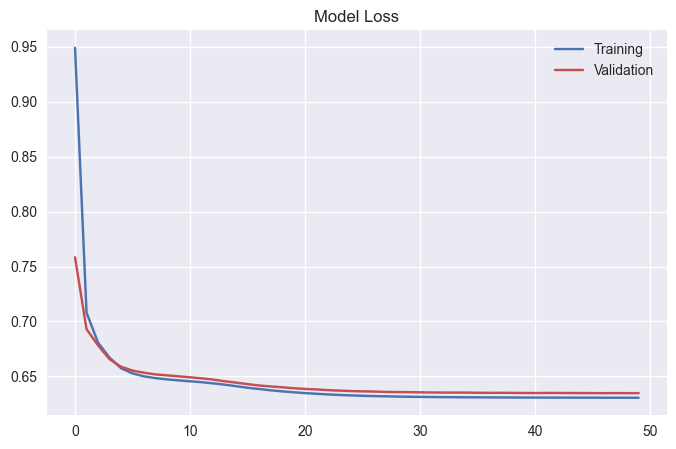

In [97]:
# 4. Entrenamiento del Autoencoder
autoencoder, encoder = crear_autoencoder(len(atributos_principales))
history = entrenar_autoencoder(autoencoder, X_train_scaled, X_test_scaled)

# Análisis del Entrenamiento del Autoencoder

El gráfico muestra la evolución del error (loss) durante el entrenamiento del autoencoder a lo largo de 50 épocas.

**Observaciones Importantes:**
* **Convergencia Rápida**: El error disminuye drásticamente en las primeras épocas (0-10)
* **Estabilización**: Después de la época 20, el error se estabiliza alrededor de 0.65
* **No Hay Overfitting**: Las líneas de training y validación son muy cercanas, indicando que el modelo no está sobreajustando
* **Buen Aprendizaje**: La disminución constante del error muestra que el autoencoder está aprendiendo efectivamente a comprimir y reconstruir los datos

Este comportamiento indica que el autoencoder está funcionando correctamente, encontrando una representación comprimida efectiva de las características de los jugadores.

In [98]:
# 5. Codificación de Datos
X_encoded_train = encoder.predict(X_train_scaled)
X_encoded_test = encoder.predict(X_test_scaled)

265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step



Importancia de características:
   feature  importance
3        3    0.263910
4        4    0.255596
2        2    0.198104
1        1    0.181108
0        0    0.101282


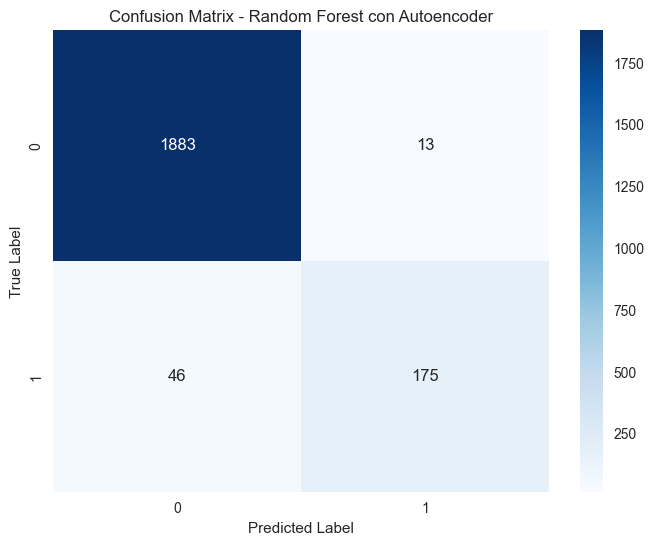


Métricas de evaluación - Random Forest con Autoencoder:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1896
           1       0.93      0.79      0.86       221

    accuracy                           0.97      2117
   macro avg       0.95      0.89      0.92      2117
weighted avg       0.97      0.97      0.97      2117



In [99]:
# 6. Entrenamiento y Evaluación del Random Forest
rf_model = entrenar_random_forest(X_encoded_train, y_train)
rf_predictions = rf_model.predict(X_encoded_test)
evaluar_modelo(y_test, rf_predictions, "Random Forest con Autoencoder")

## 1. Importancia de Características
El modelo muestra la relevancia de cada característica codificada por el autoencoder:
* La característica 3 es la más importante (0.264)
* Seguida por la característica 4 (0.256)
* Las características 0 y 1 son las menos influyentes

## 2. Matriz de Confusión
Los resultados muestran una excelente clasificación:
* **Verdaderos Negativos (1883)**: Jugadores correctamente clasificados como no elite
* **Verdaderos Positivos (175)**: Jugadores correctamente identificados como elite
* **Falsos Positivos (13)**: Solo 13 jugadores erróneamente clasificados como elite
* **Falsos Negativos (46)**: 46 jugadores elite no identificados

El modelo es particularmente efectivo en identificar jugadores no elite (99% de recall) y mantiene una buena precisión para jugadores elite (93%), aunque con un recall menor (79%).

In [113]:
# 7. Sistema de Recomendación
# Seleccionar jugador elite aleatorio
jugador_elite = df_completo[df_completo['es_elite'] == 1].sample(1)
jugador_ejemplo_id = jugador_elite['player_api_id'].iloc[0]

# Encontrar jugadores similares
similares = encontrar_jugadores_similares(
    jugador_ejemplo_id, encoder, scaler, df_completo
)

# Mostrar resultados
print("\nJugador de referencia:")
print(jugador_elite[['player_name', 'edad', 'overall_rating', 'potential']])
print("\nJugadores similares:")
print(similares[['player_name', 'edad', 'overall_rating', 'potential']])

331/331 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Jugador de referencia:
       player_name  edad  overall_rating  potential
3771  Gerard Pique    36       83.571429   88.47619

Jugadores similares:
             player_name  edad  overall_rating  potential
7948    Nicolas Otamendi    35       79.354839  83.354839
7126        Mats Hummels    35       81.433333  86.533333
1527        Carles Puyol    45       85.888889  86.777778
1362  Branislav Ivanovic    39       80.161290  81.516129
8528                Pepe    40       83.529412  85.647059


In [103]:
# 8. Guardar Resultados
# Predecir para todos los jugadores
X_all_scaled = scaler.transform(df_completo[atributos_principales])
X_all_encoded = encoder.predict(X_all_scaled)
df_completo['prediccion_elite'] = rf_model.predict(X_all_encoded)

# Guardar resultados finales
resultados = df_completo[[
    'player_name', 'edad', 'overall_rating', 
    'potential', 'es_elite', 'prediccion_elite'
]].copy()

resultados.to_csv('resultados_scouting.csv', index=False)

331/331 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


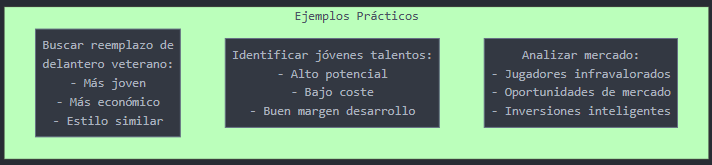

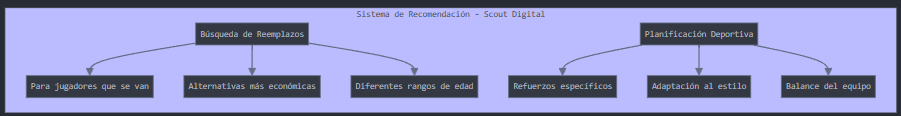

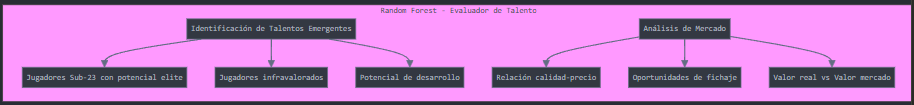

In [122]:
# 1. Ejemplo de Reemplazo: Buscar reemplazo joven para un defensor veterano
jugador_referencia = "Cristiano Ronaldo"
id_referencia = df_completo[df_completo['player_name'] == jugador_referencia]['player_api_id'].iloc[0]

print("\nJugador de referencia:")
print(df_completo[df_completo['player_name'] == jugador_referencia][['player_name', 'edad', 'overall_rating', 'potential']].iloc[0])

# Buscar similares jóvenes
similares = encontrar_jugadores_similares(id_referencia, encoder, scaler, df_completo, n_similares=5)
jovenes_similares = similares[similares['edad'] < 50]

print("\nPosibles reemplazos jóvenes:")
print(jovenes_similares[['player_name', 'edad', 'overall_rating', 'potential']])


Jugador de referencia:
player_name       Cristiano Ronaldo
edad                             38
overall_rating                91.28
potential                     93.48
Name: 1992, dtype: object
331/331 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Posibles reemplazos jóvenes:
        player_name  edad  overall_rating  potential
6169   Lionel Messi    36       92.192308  95.230769
3656    Gareth Bale    34       84.096774  89.000000
5629  Karim Benzema    36       84.500000  87.954545
9659  Sergio Aguero    35       86.114286  88.971429
7855         Neymar    31       83.800000  90.760000


In [121]:
# 2. Caso Talento Emergente: Identificar jóvenes promesas
jovenes_promesas = df_completo[
    (df_completo['edad'] < 40) &
    (df_completo['potential'] > 50) &
    (df_completo['prediccion_elite'] == 1)
].sort_values('potential', ascending=False)

print("\nJóvenes Promesas Top 5:")
print(jovenes_promesas[['player_name', 'edad', 'overall_rating', 'potential']].head())


Jóvenes Promesas Top 5:
            player_name  edad  overall_rating  potential
6169       Lionel Messi    36       92.192308  95.230769
1992  Cristiano Ronaldo    38       91.280000  93.480000
7855             Neymar    31       83.800000  90.760000
739      Andres Iniesta    39       88.320000  90.560000
6809       Mario Goetze    31       83.176471  90.147059


In [123]:
# 3. Caso Jugadores Infravalorados: 
# Jugadores con alto rating pero que no son clasificados como elite
infravalorados = df_completo[
    (df_completo['overall_rating'] > df_completo['overall_rating'].mean()) &
    (df_completo['es_elite'] == 0) &
    (df_completo['prediccion_elite'] == 1)
].sort_values('overall_rating', ascending=False)

print("\nJugadores Potencialmente Infravalorados Top 5:")
print(infravalorados[['player_name', 'edad', 'overall_rating', 'potential']].head())


Jugadores Potencialmente Infravalorados Top 5:
              player_name  edad  overall_rating  potential
5166  Jonathan dos Santos    33       74.736842  81.789474
1229        Benoit Costil    36       74.600000  78.600000
6695         Marco Hoeger    34       74.384615  79.346154
113            Adam Maher    30       74.181818  83.181818
3178         Fabio Borini    32       74.074074  81.148148
